# Coursework 1: Train a Sentiment Analysis Classifier
In this course work, you are asked to train a sentiment analysis classifier for movie reviews. The sample code below builds a simple classifier that uses tf-idf to vectorize text and a logistic regression model to make predictions.

In [4]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import ConditionalFreqDist
from nltk import FreqDist,pos_tag,ne_chunk

import string
import re

import spacy
import en_core_web_sm

from wordcloud import WordCloud

In [5]:
# load data and take a quick look
raw_data = pd.read_csv('coursework1_train.csv')
neg_reviews=raw_data[raw_data.sentiment=='neg']
pos_reviews=raw_data[raw_data.sentiment=='pos']
raw_data.head()

,Unnamed: 0,text,sentiment
0,0,Enjoy the opening credits. They're the best th...,neg
1,1,"Well, the Sci-Fi channel keeps churning these ...",neg
2,2,It takes guts to make a movie on Gandhi in Ind...,pos
3,3,The Nest is really just another 'nature run am...,neg
4,4,Waco: Rules of Engagement does a very good job...,pos


In [6]:
# check the size of the data and its class distribution
all_text = raw_data['text'].tolist()
all_lables = raw_data['sentiment'].tolist()
neg_text = neg_reviews['text'].tolist()
pos_text = pos_reviews['text'].tolist()

print('entry num', len(all_text))
print('num of pos entries', len([l for l in all_lables if l=='pos']))
print('num of neg entries', len([l for l in all_lables if l=='neg']))

entry num 40000
num of pos entries 20000
num of neg entries 20000


# Visualizing data

- The data consists of reviews of various lengths for 2 class of categories namely 'pos'-'POSITIVE' and 'neg'-'Negative'.
- Below is a histogram of length of each reviews irrespective of their class of category.
- This is definetly the first look, which helps you to have glimpse of how large the data is.

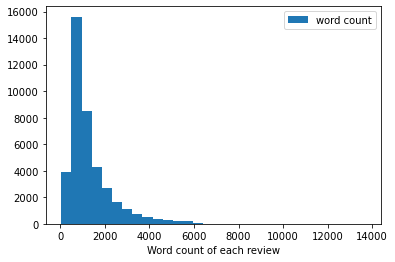

In [179]:
plt.hist([len(all_text[i]) for i in np.arange(len(all_text))],bins=30,label='word count')
plt.xlabel('Word count of each review')
plt.legend()
plt.show()

- The plot below is a combination of length of reviews of the two classes seperately.
- This plot helps you to summarize that length of positive reviews is pretty high compared with negative reviews, and ofcourse people tend take time and write a review of the movie they like.

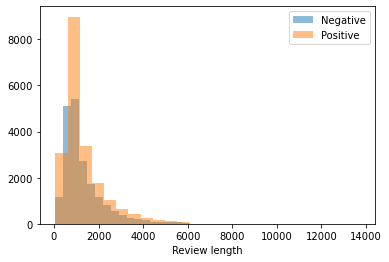

In [233]:
plt.hist([len(neg_text[i]) for i in np.arange(len(neg_text))],alpha=0.5,bins=25,label='Negative')
plt.hist([len(pos_text[j]) for j in np.arange(len(pos_text))],bins=25,alpha=0.5,label='Positive')
plt.xlabel('Review length')
plt.legend()
plt.show()

- I have seperated the dataset based on the class category and combined the reviews.
- Tokenized [using nltk word_tokenize] all the combined reviews [conidering them a corpus of words that define negativity] and had plot the FREQUENCY DISTRIBUTION of the top 10 most common words.
- We can see a lot of stop words and punctuations are on the top which definitely don't give any information

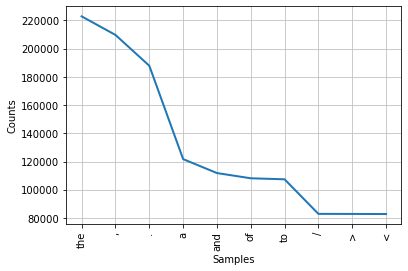

In [80]:
neg_corp=[]
neg_corp.append(' '.join([neg_text[i] for i in np.arange(len(neg_text))]))
neg_tokens=word_tokenize(neg_corp[0])
fd=FreqDist(neg_tokens)
fd.plot(10)

- Removed stop words from the entire corpus and had plot the FREQUENCY DISTRIBUTION, but there are still some words like "br","...","'s","'re" etc., that has a high frequency in the corpus.
- words like "'s","'re" arise due to tokenization [using nltk word_tokenize]. I have tried many different tokenizers and have come to a conclusion of using "TweetTokenizer" which eliminates this problem.
- Words like "br","..." were not handled using any of the known tokenizers, I have inserted these words manually into stop words and punctuation.
- Above procedure gave me below plot with most common words in negative corpus.

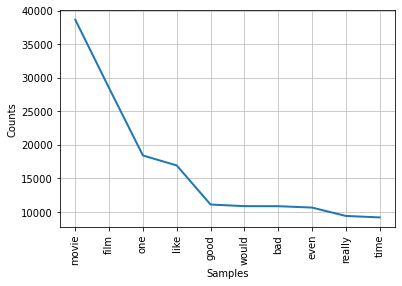

In [399]:
def remove_stopwords(sent_words,stop_punc):
    return [ww for ww in sent_words 
            if ww.lower() not in stop_words and ww not in stop_punc]

stop_words=set(stopwords.words('english'))
stop_words.add('br')
stop_punc=string.punctuation
stop_punc=stop_punc+'...'
neg_tokens=TweetTokenizer().tokenize(neg_corp[0])
stop_rem_neg_tokens=remove_stopwords(neg_tokens,stop_punc)
fd_neg=FreqDist(stop_rem_neg_tokens)
fd_neg.plot(10)

- Below is the same plot [using nltk word_tokenize] and followed by the plot using "TweetTokenizer" and stop words removal
- Both the FREQUENCY DISTRIBUTION plots help you to distinguish between the reviews of 'Positive' and 'Negative' based on the words that appear frequently in one of the corpus and doesn't in the other.

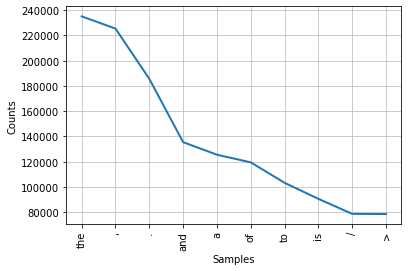

In [401]:
pos_corp=[]
pos_corp.append(' '.join([pos_text[i] for i in np.arange(len(pos_text))]))
pos_tokens=word_tokenize(pos_corp[0])
fd_pos=FreqDist(pos_tokens)
fd_pos.plot(10)

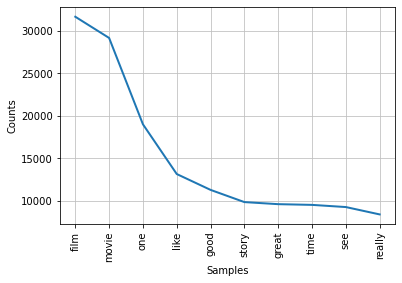

In [412]:
stop_words=set(stopwords.words('english'))
stop_words.add('br')
stop_punc=string.punctuation
pos_tokens=TweetTokenizer().tokenize(pos_corp[0])
stop_rem_pos_tokens=remove_stopwords(pos_tokens,stop_punc)
fd_pos=FreqDist(stop_rem_pos_tokens)
fd_pos.plot(10)

# Data Pre-processing

- Tokenization -> Performed tokenization using "TweetTokenizer" as the reason mentioned before in the section of visualizing the data.
- Stop words removal -> Performed stop words removal as they don't really contain any information that is used in building a model
- Stemming -> Performed stemming, so as to normalize the words to their original form, but observed some inconsistencies in some words that are the most frequent and important [fantastic, movie etc.,].
- Lemmatization -> This doesn't really make any sense using it alone without POS-Tagging. Observed the same inconsistencies as stemming.

- Looking at the word cloud image of the most frequent words after stemming has inconsistencies which can't be eliminated when used Lemmatization with pos-tagging. Better to pre-process without stemming.

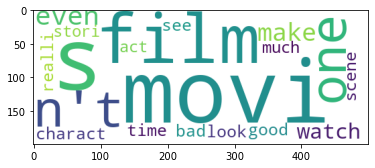

In [172]:
alltext=[]
stemmed_res=[]
alltext=remove_stopwords(neg_tokens,stop_punc)
stemmed_res=([porter.stem(j) for j in alltext])
fd_stem=FreqDist(stemmed_res)
words=fd_stem.most_common(25)
keywords=' '.join([words[i][0] for i in range(len(words))])
wcloud=WordCloud(width=500,background_color='white').generate(keywords)
plt.imshow(wcloud)

# Pre-processing data with Lemmatization and POS Tagging

- Used Lemmatization along with Pos-Tagging which really made sense.
- Used pos_tag from nltk, which in turn uses Penn Treebank Tagset for tagging pos, but lemmatizer has very limited tags and representation is different for Penn Treebank.
- Defined a function that generalizes and converts into lemmatizer's representation to convert all the words into their root forms.

In [8]:
tagged=[]
lemma_res=[]
lemmatizer = WordNetLemmatizer()

def pos_tagging(pos):
    if pos.startswith('N'):
        return 'n'
    elif pos.startswith('V'):
        return 'v'
    elif pos =='JJ' or pos == 'JJR':
        return 'a'
    elif pos.startswith('R'):
        return 'r'
    elif pos == 'JJS':
        return 's'
    else:
        return None
    
for i in np.arange(len(all_text)):
    tokens=TweetTokenizer().tokenize(all_text[i])
    alltext=remove_stopwords(tokens,stop_punc)
    tagged =pos_tag(alltext)
    lemma_res.append(' '.join([lemmatizer.lemmatize(k[0]) if pos_tagging(str(k[1]))==None else lemmatizer.lemmatize(k[0],pos_tagging(str(k[1]))) for k in tagged ]))

In [7]:
def remove_stopwords(sent_words,stop_punc):
    return [ww for ww in sent_words 
            if ww.lower() not in stop_words and ww not in stop_punc]

stop_words=set(stopwords.words('english'))
stop_words.add('br')
stop_punc=string.punctuation
stop_punc=stop_punc+'...'

# Named Entity Recognition & Chunking [NLTK]

- "NER" can be achieved using ne_chunk of nltk.Below is the tree representation of a single review. NER can't be achieved accurately without POS-Tagging.
- "NER" is used to detect NOUN Phrases and detects to which category does it belong.
- "Chunking" is used to group words to form phrases. It is used for entity detection. In this case it is very useful to group words like ['very good','really cool','very exciting' etc.,]. These are the most important words that seperate a positive review from negative.
- This kind of pre-processing helps you extract some useful information.
- On the end of 4th line of below tree, we can see NER tag of "PERSON" names. This also can be displayed using a ghost script, a perfect visualizer for trees like this. I have downloaded it, but had some issues using it.

In [220]:
pos_tagged=[]
for i in np.arange(len(all_text)):
    tokens=TweetTokenizer().tokenize(all_text[i])
    alltext=remove_stopwords(tokens,stop_punc)
    pos_tagged.append(pos_tag(alltext))

In [245]:
ner = ne_chunk(pos_tagged[0])
ner.__repr__()

'Tree(\'S\', [Tree(\'GPE\', [(\'Enjoy\', \'NNP\')]), (\'opening\', \'VBG\'), (\'credits\', \'NNS\'), ("They\'re", \'NNP\'), (\'best\', \'JJS\'), (\'thing\', \'NN\'), (\'second-rate\', \'JJ\'), (\'inoffensive\', \'JJ\'), (\'time-killer\', \'NN\'), (\'features\', \'NNS\'), (\'passable\', \'JJ\'), (\'performances\', \'NNS\'), (\'likes\', \'VBZ\'), Tree(\'PERSON\', [(\'Eric\', \'NNP\'), (\'Roberts\', \'NNP\'), (\'Martin\', \'NNP\'), (\'Kove\', \'NNP\')]), (\'main\', \'JJ\'), (\'part\', \'NN\'), (\'however\', \'RB\'), (\'goes\', \'VBZ\'), (\'newcomer\', \'JJ\'), Tree(\'PERSON\', [(\'Tommy\', \'NNP\'), (\'Lee\', \'NNP\'), (\'Thomas\', \'NNP\')]), (\'looks\', \'VBZ\'), (\'bit\', \'RB\'), (\'diminutive\', \'JJ\'), (\'kind\', \'NN\'), (\'action\', \'NN\'), (\'nevertheless\', \'RB\'), (\'occasionally\', \'RB\'), (\'manages\', \'VBZ\'), (\'project\', \'JJ\'), (\'banty-rooster\', \'JJ\'), (\'kind\', \'NN\'), (\'belligerence\', \'NN\'), (\'first\', \'JJ\'), (\'time\', \'NN\'), (\'see\', \'VB\'), ("

### NER & Chunking with "SAPCY".

In [271]:
ner_spacy = en_core_web_sm.load()
postags=ner_spacy(' '.join([i for i in alltext]))
print('-------Chunks--------')
for chunk in postags.noun_chunks:
    print(chunk) 

-------Chunks--------
OK Anatomie reinvention Horrormovie-Genre
Good actors Potente Führmann first nice ideas
Maybe would positive ´ german movie cares
familiar faces
good thrilling story gore good jokes
´ see
dubbed version course
easy watch
Germans
watch movies
´ big problem
german subtitles actors


In [294]:
for i in postags.ents:
    print('--> Name - {}\n--> Label - {}\n'.format(i.text,i.label_))

--> Name - Horrormovie-Genre
--> Label - PERSON

--> Name - Potente Führmann
--> Label - PERSON

--> Name - ´ german
--> Label - NORP

--> Name - ´
--> Label - ORG

--> Name - Germans
--> Label - NORP

--> Name - german
--> Label - NORP



# Splitting Dataset using sklearn

- Splitting the data into train and test sets. The already split train dataset can be again split into train and validation sets.
- We usually tend to split the data such that training the model includes 70% of the data and 30% is used for testing the model.
- Even using a validation set makes training 60%, validation 15% and testing 25%. These are usually standard and more preferred when having a large dataset.

In [296]:
train_text,test_text,train_labels,test_labels = train_test_split(lemma_res,all_lables,random_state=3004)

In [186]:
# data split. 
# Feel free to use differnt raios or strategies to split the data.
train_text = lemma_res[:35000]
train_labels = all_lables[:35000]
test_text = lemma_res[35000:]
test_labels = all_lables[35000:]

# Bag of Words Implementation with Multinomial Naive-Bayes

In [302]:
cvect=CountVectorizer(ngram_range=(1,3),max_features=1000)
Xtrain = cvect.fit_transform(train_text).toarray()
Xtest = cvect.transform(test_text).toarray()

encoder = LabelEncoder()
Ytrain = encoder.fit_transform(train_labels)
Ytest = encoder.transform(test_labels)

mnaive = MultinomialNB()
mnaive.fit(Xtrain,Ytrain)

Ypred = mnaive.predict(Xtest)
cm = confusion_matrix(Ytest,Ypred)

pre, rec, f1, _ = precision_recall_fscore_support(Ytest, Ypred, average='macro')
print('acc', acc)
print('precision', pre)
print('recc', rec)
print('f1', f1)

acc 0.8389
precision 0.8257758407511127
recc 0.8257151028604115
f1 0.825693932405787


# TF-IDF Implementation with Multinomial Naive-Bayes

In [300]:
max_feature_num = 1500
train_vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = train_vectorizer.fit_transform(train_text)
test_vecs = TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_).fit_transform(test_text)
# train model

mnaive = MultinomialNB()
mnaive.fit(train_vecs, train_labels)

test_pred = mnaive.predict(test_vecs)

cm=confusion_matrix(test_labels, test_pred)
acc = accuracy_score(test_labels, test_pred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_pred, average='macro')
print('acc', acc)
print('precision', pre)
print('recc', rec)
print('f1', f1)

acc 0.8389
precision 0.8389213634145903
recc 0.8389079556318225
f1 0.8388991477764918


# TF-IDF Implementation with Logistic Regression

- Tweaked the parameters of the Logistic regression model to improve the accuracy. Used Cross-Validation, so as to prevent overfitting.
- Evaluated the metrics of the model using the best parameter of the model.

In [339]:
# training: tf-idf + logistic regression
# you should explore different representations and algorithms.
from sklearn.feature_extraction.text import TfidfVectorizer
max_feature_num = 10000
train_vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=max_feature_num)
train_vecs = train_vectorizer.fit_transform(train_text)
test_vecs = TfidfVectorizer(ngram_range=(1,3),max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_).fit_transform(test_text)

# train model

clf = LogisticRegression()
param={'C':[0.001,0.01,0.1,1]}
g_cv = GridSearchCV(clf,param,cv=5)
g_cv.fit(train_vecs, train_labels)

# test model
test_pred = g_cv.predict(test_vecs)

acc = accuracy_score(test_labels, test_pred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_pred, average='macro')
print('Accuracy -->', acc)
print('precision -->', pre)
print('recall -->', rec)
print('f1 score -->', f1)

Accuracy --> 0.8885
precision --> 0.8887137736962285
recall --> 0.8885237540950164
f1 score --> 0.8884886247246082


# TF-IDF Implementation with SVM

In [ ]:
param_grid={'svc__C':[0.01,0.1,1],'svc__gamma':[0.01,0.1,1]}
pipe_minmax = make_pipeline(SVC())
grid_minmax=GridSearchCV(pipe_minmax,param_grid=param_grid,cv=5)
grid_minmax.fit(train_vecs,train_labels)
Ypred=grid_minmax.predict(test_vecs)

acc = accuracy_score(test_labels, Ypred)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_pred, average='macro')
print('Accuracy -->', acc)
print('precision -->', pre)
print('recall -->', rec)
print('f1 score -->', f1)

## SAVE YOUR TRAINED MODEL
After you have found the best model, save your trained model and other necessary components (e.g. vocabulary, vectorizer) to a file. We will load your model from the saved file and apply your trained model on some held-out test data. **At submission time, you should submit the saved model file and we will NOT re-run your code to train your model; instead, we will directly use your trained model to run test (see notebook *cw1-test.ipynb*)**. 

Below is a sample code for saving the model (and other necessary components) obtained above, using the *pickle* package in Python. *You should adjust the code to save all the necessary components for re-running your model!*

In [10]:
import pickle
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
# save model and other necessary modules
all_info_want_to_save = {
    'model': g_cv,
    'vectorizer': TfidfVectorizer(ngram_range=(1,3),max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_)
}

with open("sample_trained_model.pickle","wb") as save_path:
    pickle.dump(all_info_want_to_save, save_path)

AttributeError: 'TfidfVectorizer' object has no attribute 'vocabulary_'

In *cw1-test.ipynb*, we provide a sample code to illustrate how to re-load your saved model and apply it to some test data. 

In [ ]:
from sklearn.model_selection import GridSearchCV,train_test_split